<img src="../images/demos/FIUM.png" width="350px" class="pull-right" style="display: inline-block">


NOTA: este notebook está **obsoleto**. Es necesario arreglar la visualización de grafos (que fallaban en firefox pero ahora fallan tambien en chromium) y actualizarlo a una versión más reciente de tensorflow.

# Tensorflow

Este notebook es una introducción a tensorflow como herramienta de cómputo de propósito general, no solo para deep learning.

Para deep learning es mejor utilizar una herramienta de alto nivel como keras o pytorch.

Paquetes necesarios:
    
    pip install tensorflow keras
    
Documentación: [API](https://www.tensorflow.org/api_docs/)

## Operación básica

In [1]:
import tensorflow as tf

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy             as np
import numpy.linalg      as la

In [3]:
# Firefox no muestra los grafos, Chromium sí.

from IPython.display import clear_output, Image, display, HTML

def showgraph(graph_def=tf.get_default_graph(), max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(graph_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

La siguiente estructura nos permite reconstruir desde cero cómodamente el grafo y asociarlo a una sesión. Podemos reevaluar la celda múltiples veces sin ir añadiendo nodos.

En primer lugar creamos una "variable" con un valor inicial. (El nombre es opcional, por omisión sería "variable".)

In [4]:
g = tf.Graph()

with g.as_default():
    
    x = tf.Variable(2, name='x')
    
    init = tf.global_variables_initializer()
    
sess = tf.Session(graph=g)
sess.run(init)

In [5]:
sess.run(x)

2

In [6]:
showgraph(g)

Cuando añadimos una operación con esa variable creamos un nodo de operación, no otra variable! (Podríamos haber usado `tf.add`.)

In [7]:
g = tf.Graph()

with g.as_default():
    
    x = tf.Variable(2)
    
    y = x + 5
    
    init = tf.global_variables_initializer()
    
sess = tf.Session(graph=g)
sess.run(init)

In [8]:
sess.run(x)

2

In [9]:
sess.run(y)

7

In [10]:
showgraph(g)

El grafo muestra por omisión los nombres de los argumentos en la definición de cada nodo. La `y` que aparece en el nodo `add` no tiene nada que ver con el nodo `y` que hemos definido. Dando nombres explícitamente todo queda más claro:

In [11]:
g = tf.Graph()

with g.as_default():
    
    x = tf.Variable(2,name='XX')
    
    y = tf.add(x, tf.constant(5,name='el_5'), name='YY')

In [12]:
showgraph(g)

Para modificar variables se utilizan también nodos de operación.

In [13]:
g = tf.Graph()

with g.as_default():
    
    x = tf.Variable(2)
    
    y = x + 5
    
    modi = x.assign(y)
    
    init = tf.global_variables_initializer()
    
sess = tf.Session(graph=g)
sess.run(init)

In [14]:
sess.run(x)

2

In [15]:
sess.run(y)

7

In [16]:
sess.run(modi)

7

In [17]:
sess.run(x)

7

In [18]:
for k in range(10):
    sess.run(modi)
sess.run(x)

57

In [19]:
showgraph(g)

Cuando el grafo funciona con unas entradas externas se utilizan "placeholders" que luego se rellenan mediante un diccionario.

No hace falta para constantes, que se pueden usar directamente y se convierten automáticamente a sus propios tipos, pero quedan fijas en el grafo.

Por ejemplo, vamos a calcular la sencilla operación $y = Wx+b$.

In [20]:
g = tf.Graph()

with g.as_default():
    X = tf.placeholder(tf.float32,name='input')
    
    W = tf.Variable(tf.random_normal([1]), name='weight')
    b = tf.Variable(tf.random_normal([1]), name='bias')
    
    Y_pred = tf.add(tf.multiply(X, W), b, name='pred')

    init = tf.global_variables_initializer()
    
sess = tf.Session(graph=g)
sess.run(init)

In [21]:
sess.run(Y_pred, feed_dict={X: 5})

array([3.5514216], dtype=float32)

In [22]:
showgraph(g)

El placeholder de entrada realmente admite un tensor de cualquier profundidad. (En este caso, por la naturaleza escalar de la operación el resultado es la aplicación elementwise.)

In [23]:
sess.run(Y_pred, feed_dict={X: [5,6]})

array([3.5514216, 4.258801 ], dtype=float32)

In [24]:
sess.run(Y_pred, feed_dict={X: [[5,6],[7,8]]})

array([[3.5514216, 4.258801 ],
       [4.9661803, 5.6735597]], dtype=float32)

In [25]:
sess.run(Y_pred, feed_dict={X: np.array([[5,6],[7,8]])})

array([[3.5514216, 4.258801 ],
       [4.9661803, 5.6735597]], dtype=float32)

In [26]:
sess.run(Y_pred, feed_dict={X: np.array([[[5,6],[7,8]],[[5,6],[7,8]]])})

array([[[3.5514216, 4.258801 ],
        [4.9661803, 5.6735597]],

       [[3.5514216, 4.258801 ],
        [4.9661803, 5.6735597]]], dtype=float32)

Si queremos ajustar ese modelo lineal mediante ejemplos resueltos tenemos que añadir un placeholder para las salidas deseadas y un nodo que calcula, p. ej., el error cuadrático de la predicción.

In [27]:
g = tf.Graph()

with g.as_default():
    X = tf.placeholder(tf.float32,name='input')
    Y = tf.placeholder(tf.float32,name='output')

    W = tf.Variable(tf.random_normal([1]), name='weight')
    b = tf.Variable(tf.random_normal([1]), name='bias')
    
    Y_pred = tf.add(tf.multiply(X, W), b, name='pred')

    error = (Y - Y_pred)**2
    
    init = tf.global_variables_initializer()
    
sess = tf.Session(graph=g)
sess.run(init)

In [28]:
sess.run(error, feed_dict={X: 5, Y: 10})

array([102.68589], dtype=float32)

De nuevo, los placeholders admiten tensores de forma natural:

In [29]:
sess.run(error, feed_dict={X: [5,7], Y: [10,14]})

array([102.68589, 211.15105], dtype=float32)

In [30]:
showgraph(g)

Añadimos un nodo para sumar el coste de predicción de todos los casos:

In [31]:
g = tf.Graph()

with g.as_default():
    X = tf.placeholder(tf.float32,name='input')
    Y = tf.placeholder(tf.float32,name='output')

    W = tf.Variable(tf.random_normal([1]), name='weight')
    b = tf.Variable(tf.random_normal([1]), name='bias')
    
    Y_pred = tf.add(tf.multiply(X, W), b, name='pred')

    cost = tf.reduce_sum((Y - Y_pred)**2, name='cost')
    
    init = tf.global_variables_initializer()
    
sess = tf.Session(graph=g)
sess.run(init)

In [32]:
sess.run(cost, feed_dict={X: 5, Y: 10})

287.12143

In [33]:
sess.run(cost, feed_dict={X: [5,5], Y: [10,10]})

574.24286

In [34]:
showgraph(g)

Añadimos un nodo que "modifica las variables del grafo para que un determinado nodo disminuya su valor":

In [35]:
g = tf.Graph()

with g.as_default():
    X = tf.placeholder(tf.float32,name='input')
    Y = tf.placeholder(tf.float32,name='output')

    W = tf.Variable(tf.random_normal([1]), name='weight')
    b = tf.Variable(tf.random_normal([1]), name='bias')
    
    Y_pred = tf.add(tf.multiply(X, W), b, name='pred')

    cost = tf.reduce_sum((Y - Y_pred)**2, name='cost')
    
    learning_rate = 0.01
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
sess = tf.Session(graph=g)
sess.run(init)

El coste de ese "modelo" con unos ciertos datos tras la inicialización es

In [36]:
sess.run(cost, feed_dict={X: [5,7], Y: [10,14]})

6.2262726

Aplicamos un paso de optimización

In [37]:
sess.run(optimizer, feed_dict={X: [5,7], Y: [10,14]})

Y el coste disminuye:

In [38]:
sess.run(cost, feed_dict={X: [5,7], Y: [10,14]})

1.6772766

In [39]:
showgraph(g)

En realidad podemos calcular las derivadas de cualquier nodo respecto a las variables deseadas (que se pueden usar para hacer manualmente cualquier método de optimización que se nos ocurra). Esto se hace de nuevo añadiendo un nodo al grafo.

In [40]:
with g.as_default():
    grad = tf.gradients(Y_pred,[W,b],name='grad')

In [41]:
sess.run(grad, feed_dict={X: 5, Y:14})

[array([5.], dtype=float32), array([1.], dtype=float32)]

In [42]:
showgraph(g)

Generamos unos datos sintéticos para intentar ajustar un modelo cuadrático.

In [43]:
import matplotlib.pyplot as plt

%matplotlib inline

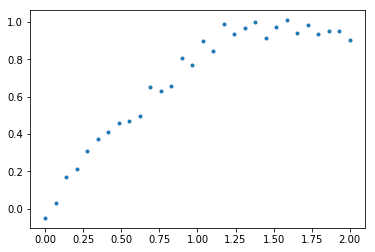

In [44]:
N = 30

x = np.linspace(0,2,30)

y = np.sin(x) + 0.05*np.random.randn(x.size)

plt.plot(x,y,'.');

Es importante normalizar el coste para que con los valores de learning rate normales el salto de gradiente no se dispare, sobrepasando el mínimo y oscilando de forma cada vez más salvaje. Aun así, la convergencia no es muy rápida en este problema (que tiene solución analítica).

In [45]:
g = tf.Graph()

with g.as_default():
    X = tf.placeholder(tf.float32,name='input')
    Y = tf.placeholder(tf.float32,name='output')

    a = tf.Variable(tf.random_normal([1]), name='a')
    b = tf.Variable(tf.random_normal([1]), name='b')
    c = tf.Variable(tf.random_normal([1]), name='c')
    
    Y_pred = tf.add(a*X**2 + b*X,c , name='pred')

    cost = tf.reduce_mean((Y - Y_pred)**2, name='cost')
    
    learning_rate = 0.1
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
        
sess = tf.Session(graph=g)
sess.run(init)

print(sess.run(cost, feed_dict={X:x, Y:y}))

1.8476713


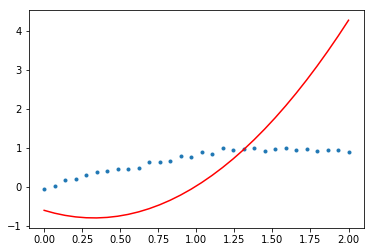

In [46]:
a_ = sess.run(a)
b_ = sess.run(b)
c_ = sess.run(c)

plt.plot(x,y,'.', x, a_*x**2+b_*x+c_, 'r');

In [47]:
print(sess.run(cost, feed_dict={X:x, Y:y}))
for k in range(1000):
    sess.run(optimizer, feed_dict={X:x, Y:y})
print(sess.run(cost, feed_dict={X:x, Y:y}))

1.8476713
0.0017979328


[-0.34743574] [1.173122] [-0.01500205]


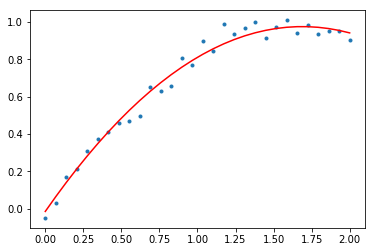

In [48]:
a_ = sess.run(a)
b_ = sess.run(b)
c_ = sess.run(c)

print(a_,b_,c_)

plt.plot(x,y,'.', x, a_*x**2+b_*x+c_, 'r');

In [49]:
showgraph(g)

Vamos a resolver el mismo problema expandiendo la entrada con las potencias deseadas, usando un vector de parámetros.

In [50]:
g = tf.Graph()

with g.as_default():
    X = tf.placeholder(tf.float32,name='input')
    Y = tf.placeholder(tf.float32,name='output')

    W = tf.Variable(tf.random_normal([1,3]), name='W')

    XV = tf.stack([X**2,X,X**0])
    
    Y_pred = tf.matmul(W,XV)
    
    cost = tf.reduce_mean((Y - Y_pred)**2, name='cost')
    
    learning_rate = 0.01
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
        
sess = tf.Session(graph=g)
sess.run(init)


print(sess.run(cost, feed_dict={X:x, Y:y}))

0.24733403


Esto solo funciona para entradas "vector", 1D. Hay operaciones que permiten ampliar y reducir dimensiones en función de las circunstancias.

In [51]:
showgraph(g)

## Problema de clasificación sencillo

In [52]:
def fig(w,h):
    plt.figure(figsize=(w,h))

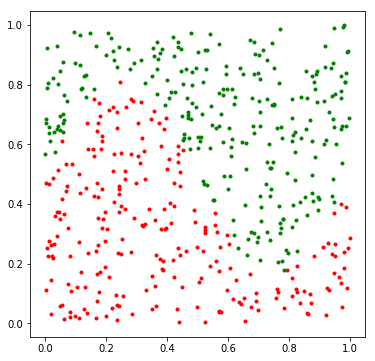

In [53]:
XX = np.random.rand(500,2)
y = np.zeros(len(XX))
y[ XX[:,1] > np.sin(2*np.pi*XX[:,0])/3 + 0.5 ] = 1
#y[ XX[:,1] > 2*(XX[:,0]-0.5)**2 + 0.4 ] = 1
YY = np.vstack([y,1-y]).T

fig(6,6)
plt.plot(XX[y==0,0],XX[y==0,1],'.r')
plt.plot(XX[y==1,0],XX[y==1,1],'.g');

Comenzamos con una máquina lineal.

In [54]:
g = tf.Graph()

with g.as_default():
    X = tf.placeholder(tf.float32,name='input')
    Y = tf.placeholder(tf.float32,name='output')

    Nin  = 2
    Nout = 2
    W = tf.Variable(tf.random_normal([Nin,Nout]), name='W')
    b = tf.Variable(tf.random_normal([Nout]), name='b')
    
    Y_pred = tf.sigmoid(tf.add(tf.matmul(X,W), b ), name='pred')

    errs = Y - Y_pred
    
    cost = tf.reduce_mean(errs**2, None, name='cost')
    
    learning_rate = 0.1
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
        
sess = tf.Session(graph=g)
sess.run(init)

data = feed_dict={X:XX, Y:YY}

print(sess.run(cost, data))

0.2846569


In [55]:
print(sess.run(cost, data))
for k in range(10000):
    sess.run(optimizer, data)
    if k%1000 == 0:
        print(sess.run(cost, data))
print(sess.run(cost, data))

0.2846569
0.284026
0.18378177
0.14939941
0.13237032
0.1232561
0.11766637
0.11386
0.11108153
0.10895703
0.107278794
0.10592204


In [56]:
np.sum((np.abs(sess.run(errs, data)) < 0.3)[:,1].astype(int))

323

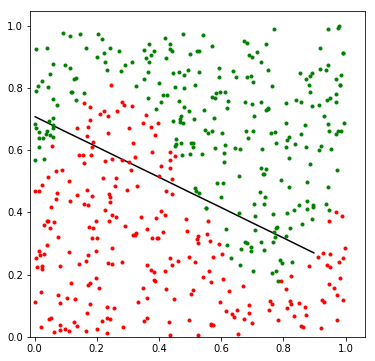

In [57]:
xy = np.mgrid[0:1:0.1,0:1:0.1]

c1,c2 = np.reshape(sess.run(Y_pred, feed_dict={X: np.reshape(xy,[2,-1]).T}).T,xy.shape)

xt,yt = xy
fig(6,6)
plt.plot(XX[y==0,0],XX[y==0,1],'.r')
plt.plot(XX[y==1,0],XX[y==1,1],'.g');
plt.contour(xt,yt, c2-0.5, 0, colors=['k']);
plt.axis('equal');

In [58]:
sess.run(Y_pred, feed_dict={X: np.array([[0.2,0]])})

array([[0.0406928, 0.9646765]], dtype=float32)

In [59]:
showgraph(g)

Este problema requiere una capa oculta (intermedia):

In [60]:
g = tf.Graph()

with g.as_default():
    X = tf.placeholder(tf.float32,name='input')
    Y = tf.placeholder(tf.float32,name='output')

    Nin  = 2
    Nh   = 5
    Nout = 2
    
    W1 = tf.Variable(tf.random_normal([Nin,Nh]), name='W1')
    b1 = tf.Variable(0*tf.random_normal([Nh]), name='b1')
    
    Y1 = tf.sigmoid(tf.matmul(X,W1)+ b1, name='Y1')
    
    W2 = tf.Variable(tf.random_normal([Nh,Nout]), name='W2')
    b2 = tf.Variable(0*tf.random_normal([Nout]), name='b2')
    
    Yp = tf.sigmoid(tf.matmul(Y1,W2)+ b2, name='Yp')

    errs = Y - Yp
    
    cost = tf.reduce_mean(errs**2, None, name='cost')
    
    learning_rate = 0.1
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    init = tf.global_variables_initializer()
        
sess = tf.Session(graph=g)
sess.run(init)

data = feed_dict={X:XX, Y:YY}

print(sess.run(cost, data))

0.2747168


In [61]:
print(sess.run(cost, data))
for k in range(10000):
    sess.run(optimizer, data)
    if k%1000 == 0:
        print(sess.run(cost, data))
print(sess.run(cost, data))

0.2747168
0.27443078
0.1616697
0.11063657
0.09901396
0.09666358
0.09537488
0.09108313
0.08240666
0.069202065
0.058469992
0.04973837


In [62]:
np.sum((np.abs(sess.run(errs, data)) < 0.3)[:,1].astype(int))

410

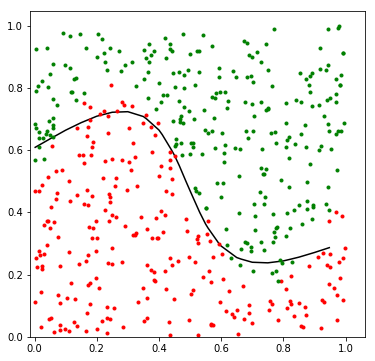

In [63]:
xy = np.mgrid[0:1:0.05,0:1:0.05]

c1,c2 = np.reshape(sess.run(Yp, feed_dict={X: np.reshape(xy,[2,-1]).T}).T,xy.shape)

xt,yt = xy
fig(6,6)
plt.plot(XX[y==0,0],XX[y==0,1],'.r')
plt.plot(XX[y==1,0],XX[y==1,1],'.g');
plt.contour(xt,yt, c1-c2, 0, colors=['k']);
plt.axis('equal');
#plt.savefig('result.svg')

In [64]:
showgraph(g)

## MNIST

In [65]:
mnist = np.load("../data/mnist.npz")
xl,yl,xt,yt = [mnist[d] for d in ['xl', 'yl', 'xt', 'yt']]
print(xl.shape, yl.shape)
print(xt.shape, yt.shape)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


In [66]:
from IPython.display import clear_output

In [67]:
def mkSaver(path):
    saver = tf.train.Saver(tf.global_variables())
    def save(n):
          saver.save(sess, path+'/model', global_step=n)
    def restore():
        saver.restore(sess, tf.train.latest_checkpoint(path))
    return save,restore

### Máquina lineal

In [68]:
g = tf.Graph()

with g.as_default():
    
    x = tf.placeholder("float", shape=[None, 784])
    y_ = tf.placeholder("float", shape=[None, 10])
    
    W = tf.Variable(tf.zeros([784,10]))
    b = tf.Variable(tf.zeros([10]))
    
    y = tf.nn.softmax(tf.matmul(x,W) + b)
    
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    init = tf.global_variables_initializer()
    save,restore = mkSaver('models/linear')
    
sess = tf.Session(graph=g)
sess.run(init)

In [69]:
print(sess.run(accuracy, feed_dict={x: xt, y_: yt}))

0.098


In [70]:
def accu(X,Y):
    xb = X.reshape(-1,1000,784)
    yb = Y.reshape(-1,1000,10)
    acc = np.mean([sess.run(accuracy,feed_dict={x: xb[k], y_: yb[k]})
                   for k in range(len(xb))])
    return acc

In [71]:
accu(xt,yt)

0.098000005

In [72]:
def epoch(X,Y, batch=100):
    n = len(X)
    perm = list(range(n))
    np.random.shuffle(perm)
    xb = X[perm]
    xb = xb.reshape(-1,batch,784)
    yb = Y[perm]
    yb = yb.reshape(-1,batch,10)
    for k in range(n//batch):
        sess.run(train_step,feed_dict={x: xb[k], y_: yb[k]})

In [73]:
for p in range(10):
    epoch(xl,yl)
    print(accu(xt,yt))

0.9118
0.9144
0.9188
0.9197
0.912
0.91480005
0.9215
0.9229
0.9113
0.9188


In [74]:
#save(3000)
#restore()

In [75]:
#accu(xt,yt)

### Convolutional network

In [76]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1], padding='SAME')

In [77]:
g = tf.Graph()

with g.as_default():
    
    x = tf.placeholder("float", shape=[None, 784])
    y_ = tf.placeholder("float", shape=[None, 10])
    
    x_image = tf.reshape(x, [-1,28,28,1])
    
    
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


    keep_prob = tf.placeholder("float")
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    init = tf.global_variables_initializer()
    save,restore = mkSaver('../data/models/convo')
    
sess = tf.Session(graph=g)
sess.run(init)

In [78]:
def accu(X,Y):
    xb = X.reshape(-1,1000,784)
    yb = Y.reshape(-1,1000,10)
    acc = np.mean([sess.run(accuracy,feed_dict={x: xb[k], y_: yb[k], keep_prob: 1.0})
                   for k in range(len(xb))])
    return acc

In [79]:
accu(xt,yt)

0.1691

In [80]:
def epoch(X,Y, batch=100):
    n = len(X)
    perm = list(range(n))
    np.random.shuffle(perm)
    xb = X[perm]
    xb = xb.reshape(-1,batch,784)
    yb = Y[perm]
    yb = yb.reshape(-1,batch,10)
    for k in range(n//batch):
        sess.run(train_step,feed_dict={x: xb[k], y_: yb[k], keep_prob: 0.5})

In [81]:
if False:
    for p in range(10):
        epoch(xl,yl)
        print(accu(xt,yt))

    wget http://robot.inf.um.es/material/va/models.tar.gz

In [82]:
#save(3000)
restore()

INFO:tensorflow:Restoring parameters from ../data/models/convo/model-3333


In [83]:
accu(xt,yt)

0.9922999

Prueba con imagen "real"

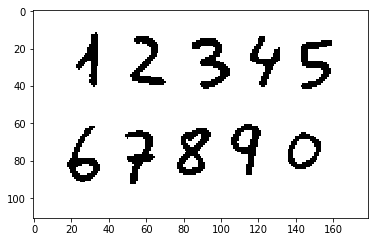

In [84]:
import cv2 as cv

digits = cv.cvtColor(cv.imread('../images/mydigits.png'),cv.COLOR_BGR2RGB);
plt.imshow(digits);

ret, gt = cv.threshold(cv.cvtColor(digits,cv.COLOR_RGB2GRAY),189,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(gt,'gray')
gt = 255-gt

def center(p):
    r,c = p.shape
    rs = np.outer(range(r),np.ones(c))
    cs = np.outer(np.ones(r),range(c))
    s = np.sum(p)
    my  = np.sum(p*rs) / s
    mx  = np.sum(p*cs) / s
    return mx,my

def boundingBox(c):
    (x1, y1), (x2, y2) = c.min(0), c.max(0)
    return (x1, y1), (x2, y2)

def adaptsize(x):
    h,w = x.shape
    s = max(h,w)
    h2 = (s-h)//2
    w2 = (s-w)//2
    if h2==0:
        z1 = np.zeros([s,w2])
        z2 = np.zeros([s,s-w-w2])
        y  = np.hstack([z1,x,z2])
    else:
        z1 = np.zeros([h2,s])
        z2 = np.zeros([s-h-h2,s])
        y  = np.vstack([z1,x,z2])
    y = cv.resize(y,(20,20))/255
    mx,my = center(y)
    H = np.array([[1.,0,4-(mx-9.5)],[0,1,4-(my-9.5)]])
    return cv.warpAffine(y,H,(28,28))

a,contours,b = cv.findContours(gt.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
ok = [ boundingBox(x.reshape(len(x),2)) for x in contours ]
ok = [ adaptsize(gt[y1:y2,x1:x2]) for (x1,y1),(x2,y2) in ok ]

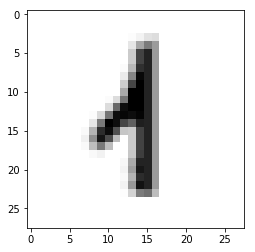

In [85]:
dig = ok[9]
plt.imshow(1-dig,'gray');

In [86]:
pred = sess.run(y, feed_dict={x: dig.reshape(1,-1), keep_prob: 1.0})

print(pred)

np.argmax(pred)

[[3.2144257e-07 9.5542973e-01 2.9735313e-06 3.1032444e-06 4.4401556e-02
  5.4769561e-07 9.5822688e-06 1.4673026e-04 1.2765067e-06 4.0376517e-06]]


1

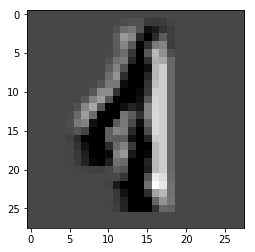

In [87]:
plt.imshow(sess.run(h_conv1, feed_dict={x: [dig.flatten()]})[0,:,:,2],'gray',interpolation='nearest');

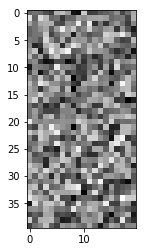

In [88]:
plt.imshow(
    np.bmat([ [sess.run(W_conv1)[:,:,0,j*4+k] 
               for k in range(4)] for j in range(8)]),'gray',interpolation='nearest');

## Keras

In [89]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Softmax, Flatten

model = Sequential()
model.add(Conv2D(input_shape=(28,28,1), filters=32, kernel_size=(5,5), strides=1,
                 padding='same', use_bias=True, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(5,5), strides=1,
                 padding='same', use_bias=True, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024))
model.add(Dropout(rate=0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

Using TensorFlow backend.


In [90]:
#from keras.utils import plot_model
#plot_model(model, to_file='CNNmodel.png')

<img src="../images/demos/CNNmodel.png" width="200px">

In [91]:
if False:
    model.fit(xl.reshape(-1,28,28,1), yl, epochs=50, batch_size=500)

In [92]:
model.evaluate(xt.reshape(-1,28,28,1),yt, batch_size=500)

10000/10000 [==============================] - 8s 781us/step


[2.3131133198738096, 0.07859999965876341]

In [93]:
#model.save('digits.keras')

In [94]:
#wget https://robot.inf.um.es/material/va/digits.keras

model.load_weights('../data/models/digits.keras')

array([0, 7, 8, 6, 9, 5, 3, 4, 2, 1])

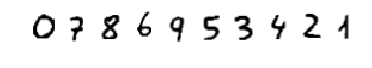

In [95]:
plt.imshow(-np.hstack([x.reshape(28,28) for x in ok]),'gray'); plt.axis('off');

model.predict_classes(np.array(ok).reshape(-1,28,28,1))

## CIFAR-10

    wget https://robot.inf.um.es/material/va/cifar-10-python.tar.gz

In [96]:
def unpickle(file):
    import pickle
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

In [97]:
r = unpickle('../images/cifar-10-batches-py/batches.meta')

In [98]:
r

{'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_cases_per_batch': 10000,
 'num_vis': 3072}

In [99]:
r = unpickle('../images/cifar-10-batches-py/data_batch_1')

In [100]:
r['data'].shape

(10000, 3072)

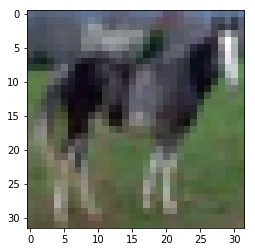

In [101]:
plt.imshow(r['data'][37].reshape(3,32,32).transpose(1,2,0));

## imagenet

[imagenet database](http://www.image-net.org/)

In [2]:
%matplotlib inline

import numpy             as np
import cv2               as cv
import matplotlib.pyplot as plt

import urllib.request as urllib2

In [15]:
import urllib

url = "http://image-net.org/api/text/imagenet.synset.geturls?wnid="

def urls(wnid):
    f = urllib.request.urlopen(url+wnid)
    output = f.read().decode("utf-8")
    return output.splitlines()

In [16]:
dogs = urls('n02084071')
len(dogs)

1604

In [17]:
wall = urls('n09474412')

len(wall)

20

In [18]:
# leemos la imagen de esta manera para disponer de timeout en la conexión
def url_to_image(url):
    resp = urllib.request.urlopen(url, timeout=2)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv.imdecode(image, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    return image

Las imágenes están off-line :(

In [7]:
selected = dogs[:100]

# una forma simple de detectar la imagen eliminada de flickr
def ok(x):
    return x.sum() != 142451337

imgs = []
for f in selected:
    try:
        img = url_to_image(f)
        assert ok(img)
        imgs += [img]
        print('.',end='')
    except:
        print('x',end='')

print()
len(imgs)

x....xx..x..x.xx..........x..xx......x..x.xx....x.....xx.........xx..x..x.x....x.x..xx.xxx.....xxxxx


66

In [8]:
def centersquare(img):
    h,w = img.shape[:2]
    if h==w:
        return img
    elif h>w:
        h2 = (h-w)//2
        return img[h2:h2+w]
    else:
        w2 = (w-h)//2
        return img[:,w2:w2+h]

def chunks(l, n):
     return [ l[i:i+n] for i in range(0, n*(len(l)//n), n) ]

def blockimage(xs):
    return np.vstack(map(np.hstack,xs))

In [9]:
def work(x):
    return cv.resize(centersquare(x),(100,100))

ok = [work(x) for x in imgs]

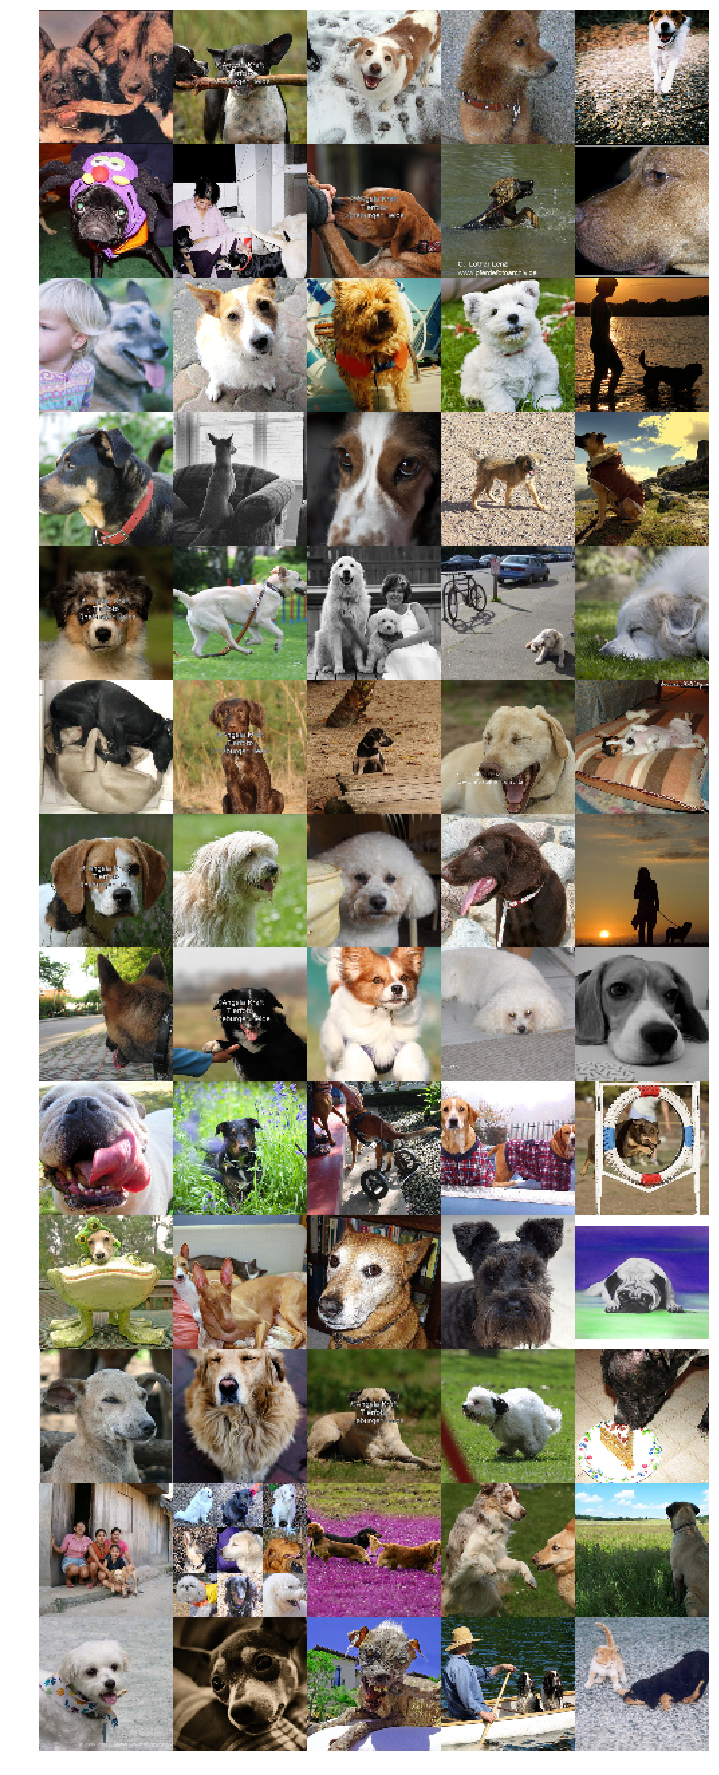

In [11]:
plt.figure(figsize=(12,40))
plt.imshow(blockimage(chunks(ok,5))); plt.axis('off');

## Inception

In [1]:
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
img = image.load_img("../images/naranjas/naranjas4.jpg", target_size=(299, 299))

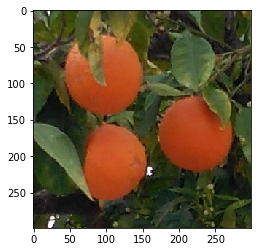

In [3]:
plt.imshow(img);

In [4]:
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 2s 0us/step


In [4]:
model = InceptionV3(weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [5]:
arr = image.img_to_array(img)
arr = np.expand_dims(arr, axis=0)
arr = preprocess_input(arr)
print("Dimensiones del tensor", arr.shape)

preds = model.predict(arr)
print('Predicciones:', decode_predictions(preds, top=3)[0])

Dimensiones del tensor (1, 299, 299, 3)

Predicciones: [('n07747607', 'orange', 0.94408035), ('n12620546', 'hip', 0.020757709), ('n07749582', 'lemon', 0.01639331)]
